#  XPCS   Pipeline 

 "This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

##Version--Dec 20,2015

## NSLS2 data retrieval imports

In [1]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [2]:
#hdr = db[{{ uid }}]

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time
from ipywidgets import interact

In [4]:
cd /XF11ID/analysis/Analysis_Pipelines/Develop/

/XF11ID/analysis/Analysis_Pipelines/Develop


In [7]:
%run develop.py
%run Time_Correlation_Functions.py
%run speckle.py

In [8]:
%matplotlib notebook
#%matplotlib inline

# Users put 
* uid for Bluesky Scan
* filename for acquiring data directly by EigerSofteare

In [9]:
BlueScan = True
DirectAcq = False
detector = 'eiger_4M_cam_img_image_lightfield'  #for 4M

# Users put uid here

In [10]:
if BlueScan:
    uid = '54614d43'
    #uid = '95782687'
    uid = '95782687'
    uid= 'ff9f20c0'
    uid='71720966'
    uid='1663d34a'
    uid = 'f505e052-3baa-47d4-bdc4-61c2eb1bcc7a'  #sid= 551, 1%PEG, 
    uid='ee6975a1-9161'   #1% wt PEG
    uid='ec41569e'  #a gisaxs example, 
    uid = 'ffe9d518'  # 10 mTorr 1sec/frame
 
    
else:
    uid = '/XF11ID/data/2015/11/23/d01ab510-3cf3-4719-bee3_795_master.h5' 

### Get data

In [13]:
if BlueScan:
    hdr = db[uid]
    ev, = get_events(  hdr, [detector] )
    imgs = ev['data'][detector]
else:    
    imgs =  Images(uid)
print (imgs)
Nimg=len(imgs)

hdf5 path = /XF11ID/data/2015/11/8/3f84f57d-79b7-4a10-8b51_5_master.h5
<Frames>
Length: 15000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


### Get data path

In [14]:
if BlueScan:
    from datetime import datetime
    dt = datetime.fromtimestamp(hdr['start'].time)
    path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
else:
    path ='/XF11ID/analysis/2015/11/23/' 
path

'/XF11ID/analysis/2015/11/8/'

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [15]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 1830.0,
 'count_time': 1.0,
 'detector_distance': 4.8400002,
 'frame_time': 1.00001,
 'framerate': 0.99998998651994853,
 'incident_wavelength': 1.3776,
 'pixel_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [16]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4812.        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## load a mask
#### load the mask saved in the mask_pipeline

In [17]:
mask = np.load( path +  str(uid)+ "_mask.npy")


### Reverse the mask in y-direction due to the coordination difference between python and Eiger software 

In [18]:
maskr = mask[::-1,:]

## Plot the mask

<IPython.core.display.Javascript object>


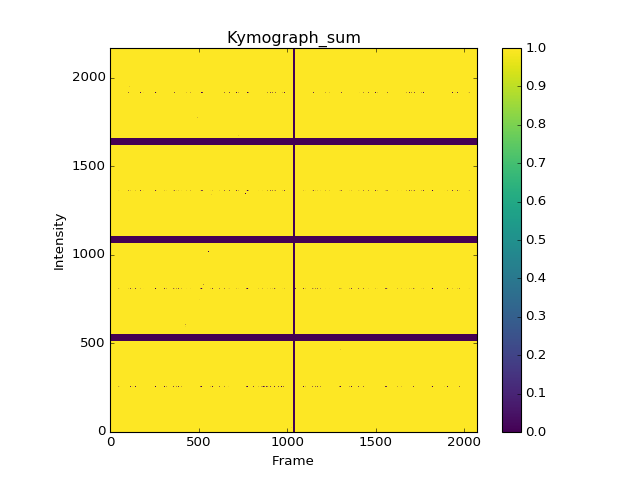

In [19]:
fig, ax = plt.subplots()
im=ax.imshow(maskr, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.

### Note : Provide the number of images that you want to browse

In [20]:
def view_image(i):    
    fig, ax = plt.subplots()
    ax.imshow(imgs[i]*mask, interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm(vmin=0.001, vmax=1e1) )
    ax.set_title("Browse the Image Stack")
    plt.show()
    

In [21]:
#interact(view_image, i=(0, Nimg-1))

## Movie

In [22]:
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        im=ax.imshow(imgs[i]*mask,  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.01, vmax=10 ) )
        ax.set_title("images_%s"%i)
        
        time.sleep( sleeps )
        plt.draw()
    #fig.colorbar(im)
        
#view_image(.2, 0, 2)

### hey, let's see if any images are bad!

#### load the image intensity (kymograph) saved in the mask_pipeline

In [23]:
kymo_sum = np.load( path +  str(uid)+"_kymo_sum.npy" ) 

In [100]:
bad_frames = np.where( kymo_sum > 1e6)[0]
bad_frames

array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784])

<IPython.core.display.Javascript object>


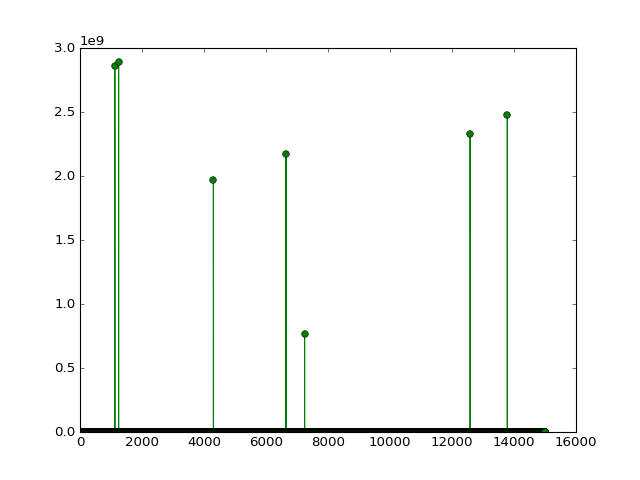

In [25]:
fig, axes = plt.subplots(  )
axes.plot( kymo_sum, '-go'  ) 
ax.set_ylabel('Intensity')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_sum') 
plt.show()

### Get the Averaged Image Data

#### load the average intensity saved in the mask_pipeline

In [26]:
avg_img = np.load( path + str(uid)+"_avg_img.npy" )
avg_imgm =  avg_img * mask

### Reverse the image in y-direction due to the coordination difference between python and Eiger software 

In [27]:
avg_imgr  = avg_img[::-1,:] 
avg_imgmr  = avg_imgm[::-1,:] 

# NOTE:


* mask:   the mask file in the python conventional coordination
* maskr:  the mask file in the eiger coordination (maksr = mask[::-1,:])
* avg_img: the average intensity frames in the python conventional coordination
* avg_imgm: the maksed average intensity frames in the python conventional coordination (avg_imgm =  avg_img * mask)   
* avg_imgr: the average intensity frames in the eiger coordination (avg_imgr  = avg_img[::-1,:] )
* avg_imgmr: the maksed average intensity frames in the eiger coordination (avg_imgmr  = avg_imgm[::-1,:] )

## Plot the averged image with the mask

<IPython.core.display.Javascript object>


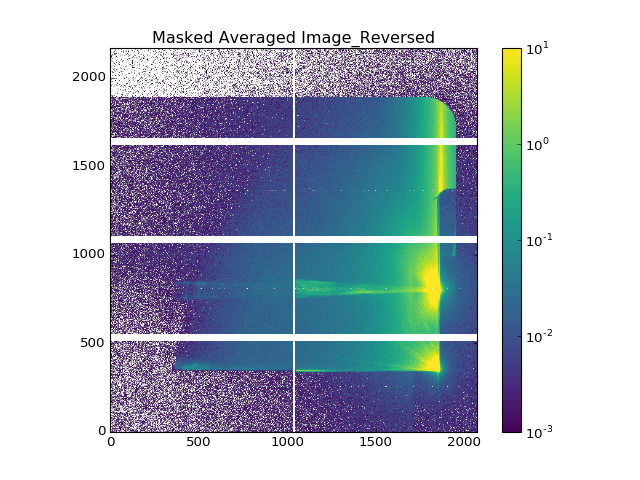

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(avg_imgmr, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image_Reversed")
fig.colorbar(im)
plt.show()

## Note:  experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)


In [29]:
# The physical size of the pixels
dpix = imgs.md['x_pixel_size'] * 1000.  
lambda_ = imgs.md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4810        # detector to sample distance (mm)

exposuretime= imgs.md['count_time']
acquisition_period = imgs.md['frame_time']

# deadtime= 0   # 60e-6 
# timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

timeperframe, exposuretime

(1.00001, 1.0)

## GiSAXS get q-map (qz and qr)

### Users put incident-Beam and Reflection_Beam Centers here!!!

In [30]:
inc_x0 = 1871
inc_y0 = 339
refl_x0 = 1871
refl_y0 = 811      #1670
Lsd= 4.81
lamda= lambda_  #12.4/9

In [31]:
lamda

1.3776

In [32]:
alphaf,thetaf, alphai, phi = get_reflected_angles( inc_x0, inc_y0,refl_x0 , refl_y0, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


In [33]:
qx, qy, qr, qz = convert_gisaxs_pixel_to_q( inc_x0, inc_y0,refl_x0,refl_y0, lamda=lamda, Lsd=Lsd )

The incident_angle (alphai) is: 0.210835132612


In [34]:
#show_qz(qz)
#show_qr(qr)
#show_alphaf(alphaf)

<IPython.core.display.Javascript object>


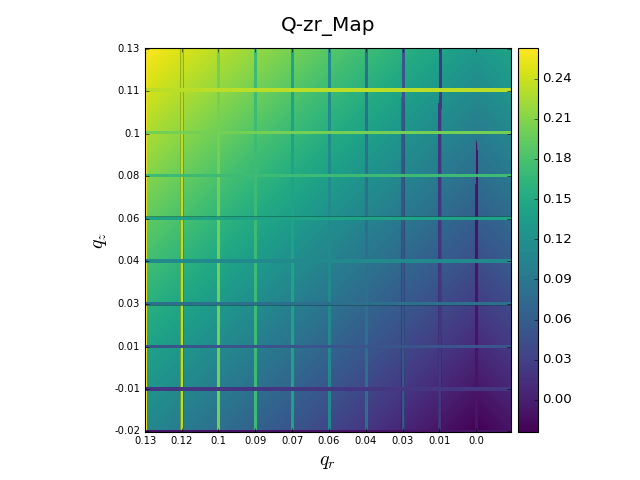

In [35]:
ticks = show_qzr_map(  qr, qz, inc_x0, data = None, Nzline=10, Nrline= 10   )

<IPython.core.display.Javascript object>


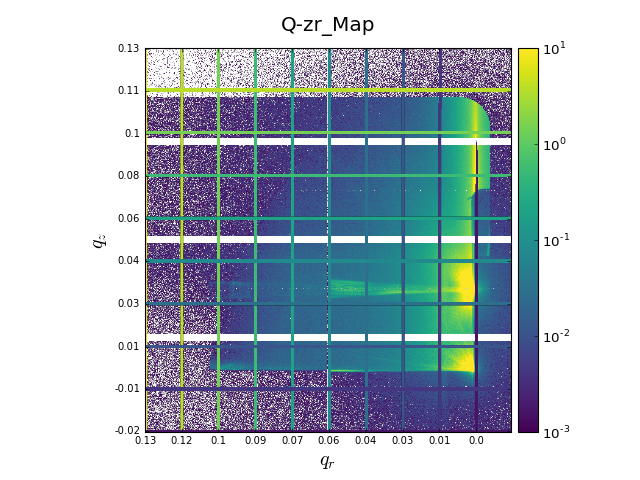

In [36]:
ticks = show_qzr_map(  qr,qz, inc_x0, data = avg_imgmr, Nzline=10,  Nrline=10   )

# Get q||-intensity

## Users put cuts here!!!

In [37]:
#to make two-qz, from 0.018 to 0.046, width as 0.008, 

qz_width = 0.008
qz_start = 0.018 + qz_width/2
qz_end = 0.046  -  qz_width/2
qz_num= 2


#to make one-qr, from 0.02 to 0.1, and the width is 0.1-0.012
qr_width =  0.1-0.02
qr_start =    0.02 + qr_width  /2
qr_end =  0.01 -  qr_width  /2
qr_num = 1
 
Qr = [qr_start , qr_end, qr_width, qr_num]
Qz=  [qz_start,   qz_end,  qz_width , qz_num ]

In [38]:
Qr,Qz

([0.06, -0.03, 0.08, 1], [0.022, 0.041999999999999996, 0.008, 2])

In [39]:
new_mask = np.ones_like( avg_imgr)
new_mask[ :, 1020:1045] =0

The qr_edge is:  [ 0.02  0.1 ]
The qr_center is:  [ 0.06]
The qz_edge is:  [ 0.018  0.026  0.038  0.046]
The qz_center is:  [ 0.022  0.042]


<IPython.core.display.Javascript object>


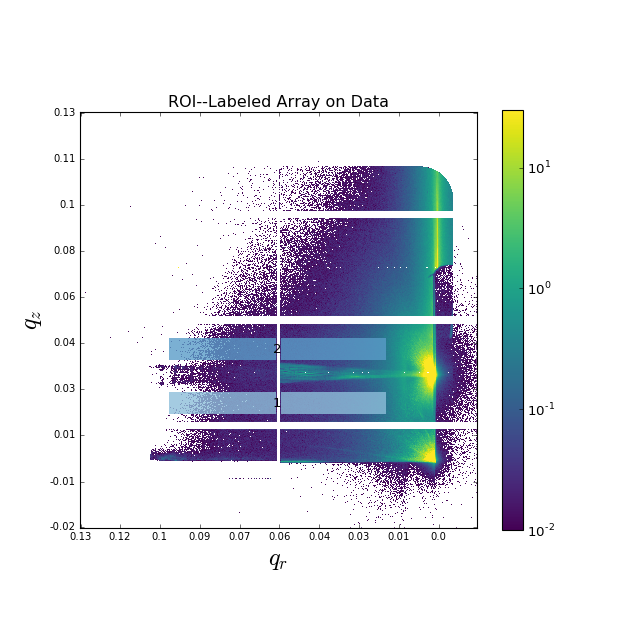

<IPython.core.display.Javascript object>


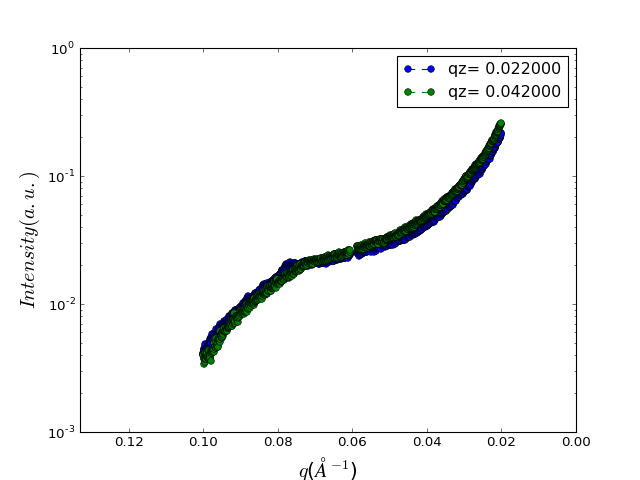

In [53]:
qr_1d = get_1d_qr( avg_imgr, Qr, Qz, qr, qz, inc_x0,  new_mask,  True, ticks, .8)

## User gives the interested Qz,Qr here!!! 
To define the ROI
* user can use pixel value
* user also can use qz,qr value

In [ ]:
# qz_start = qz[670,0]
# qz_end = qz[950,0]
# qz_num= 2
# qz_width = (qz_end - qz_start)/(qz_num +1)

# qr_start =  qr[600,1700]
# qr_end = qr[600,0]
# qr_num = 15
# qr_width = ( qr_end- qr_start)/qr_num

In [41]:
qz_start = 0.022
qz_end = 0.042
qz_num= 2
qz_width = 0.008 #(qz_end - qz_start)/(qz_num +1)

qr_start =  0.01
qr_end = 0.09
qr_num = 10
qr_width = ( qr_end- qr_start)/qr_num

## Create label array (Qz, Qr, Qzr boxes)

In [42]:
qr_edge, qr_center = get_qedge(qr_start , qr_end, qr_width, qr_num )
qz_edge, qz_center = get_qedge( qz_start,   qz_end,   qz_width , qz_num )
     
#print ('The qr_edge is:  %s\nThe qr_center is:  %s'%(qr_edge, qr_center))
#print ('The qz_edge is:  %s\nThe qz_center is:  %s'%(qz_edge, qz_center)) 
    
label_array_qz = get_qmap_label( qz, qz_edge)
label_array_qr = get_qmap_label( qr, qr_edge)
label_array_qzr,qzc,qrc = get_qzrmap(label_array_qz, label_array_qr,qz_center, qr_center  )

labels_qzr, indices_qzr = roi.extract_label_indices( label_array_qzr  )
labels_qz, indices_qz = roi.extract_label_indices( label_array_qz  )
labels_qr, indices_qr = roi.extract_label_indices( label_array_qr  )

num_qz = len(np.unique( labels_qz ))
num_qr = len(np.unique( labels_qr ))
num_qzr = len(np.unique( labels_qzr ))


## Extract the labeled array

In [43]:
boxes = label_array_qzr 
box_maskr = boxes*maskr


In [44]:
qind, pixelist = roi.extract_label_indices(   box_maskr  )
noqs = len( np.unique(qind) )
nopr = np.bincount(qind, minlength=(noqs+1))[1:] 

## Number of pixels in each q ring

In [45]:
nopr

array([25088, 12544, 12544, 12544, 12544, 12544, 11760, 12534, 12544,
       12544, 25088, 12544, 12544, 12544, 12544, 12544, 11760, 12544,
       12544, 12544])


## plot average image with interested Q-regions (boxes)

<IPython.core.display.Javascript object>


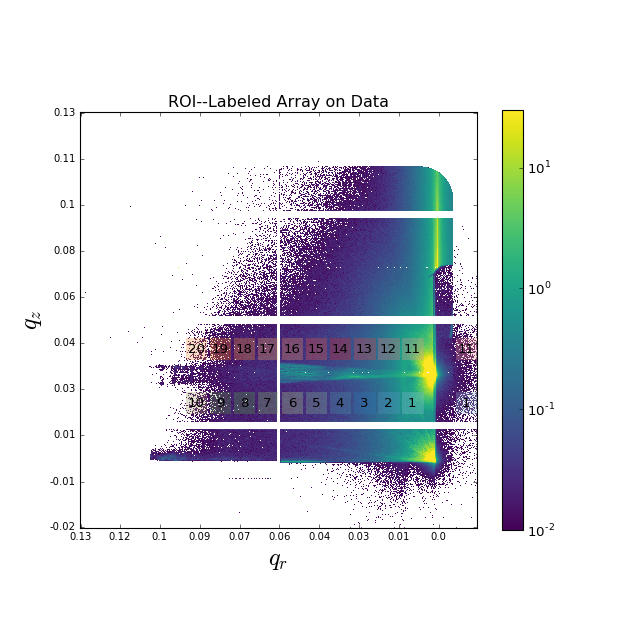

In [46]:
show_qzr_roi( avg_imgr, box_maskr, inc_x0, ticks)

##  Kymograph(waterfall plot) of the max-intensity ring

In [47]:
imgs_ =imgs
imgsr = Reverse_Coordinate(imgs_, maskr)    

In [48]:
t0 = time.time()

data_pixel =   Get_Pixel_Array( imgsr, pixelist).get_data()
#data_pixel = np.load( path + 'uid_%s_data_pixel.npy'%(uid) )
run_time(t0)

Total time: 0.24 min


In [ ]:
#data_pixel = np.load( path + 'uid_%s_data_pixel.npy'%(uid) )

In [49]:
data_pixel.shape

(15000, 274390)

### users put the number of ring with max intensity here

In [50]:
max_inten_box =1

In [51]:
#kymo = roi.kymograph(imgsr, ring_mask, num = max_inten_ring)

In [52]:
pixelist_qi =  np.where( qind == max_inten_box )[0]         
data_pixel_qi = data_pixel[:,pixelist_qi]  

In [54]:
data_pixel_qi.shape

(15000, 25088)

<IPython.core.display.Javascript object>


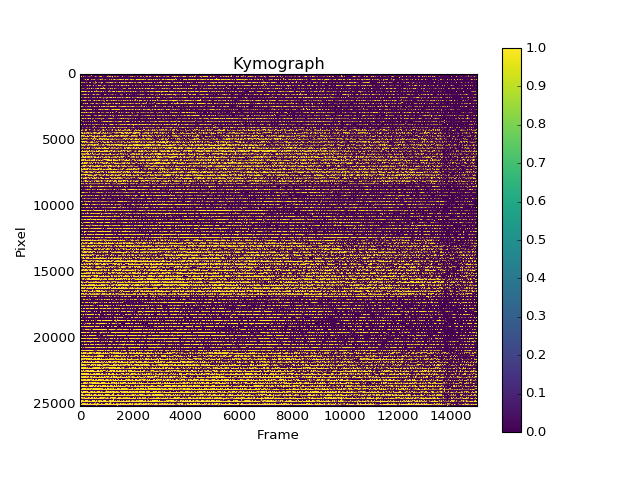

In [55]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph')

im = ax.imshow(data_pixel_qi.T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(.5)
plt.show()

<IPython.core.display.Javascript object>


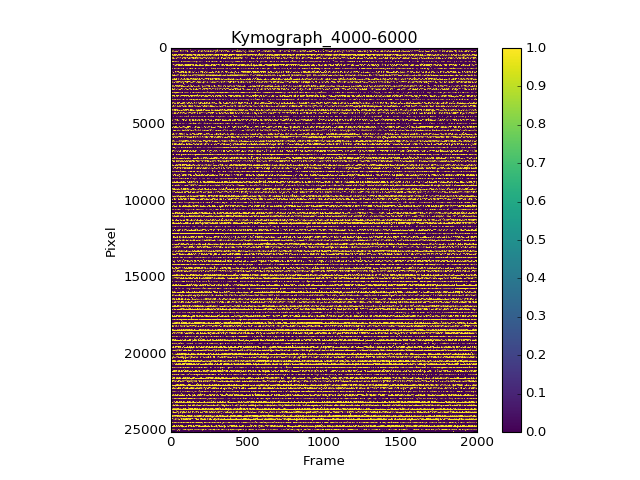

In [56]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_ylabel('Pixel')
ax.set_xlabel('Frame')
ax.set_title('Kymograph_4000-6000')

im = ax.imshow(data_pixel_qi[4000:6000,:].T, cmap='viridis', vmax=1.0)
fig.colorbar( im   )
ax.set_aspect(.1)
plt.show()

##  Mean intensities for each ring

In [57]:
mean_inten = get_mean_intensity( data_pixel, qind)
#np.save( path + 'uid_%s_mean_inten'%uid, mean_inten  )


In [ ]:
#mean_inten_  = np.load( path + 'uid_%s_mean_inten.npy'%(uid) )
#mean_inten = mean_inten_.item()

<IPython.core.display.Javascript object>


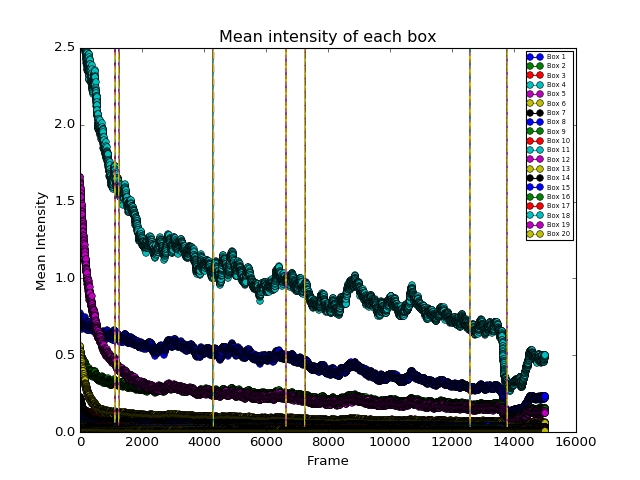

In [58]:
times = np.arange(  mean_inten[1].shape[0]   )  #*timeperframe  # get the time for each frame

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Mean intensity of each box")
for i in range(  num_qzr  ):
    ax.plot(times, mean_inten[i+1], '--o', label="Box "+str(i+1))
    ax.set_xlabel("Frame")
    ax.set_ylabel("Mean Intensity")
    ax.set_ylim(0, 2.5)
    
ax.legend( loc='best', fontsize = 6) 
plt.show()

## One time Correlation

Note : Enter the number of levels and number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-xray/scikit-xray/blob/master/skxray/core/correlation.py

In [59]:
nopr

array([25088, 12544, 12544, 12544, 12544, 12544, 11760, 12534, 12544,
       12544, 25088, 12544, 12544, 12544, 12544, 12544, 11760, 12544,
       12544, 12544])

In [60]:
good_start =4000
good_end = 12001

imgs_ =imgs[good_start: good_end-1]
imgsr = Reverse_Coordinate(imgs_, mask) 

num_buf = 8


In [ ]:
g2_tx1, lag_steps_tx1 = autocor_one_time( num_buf,  box_maskr, imgsr, num_lev=None,
                                bad_images=None, threshold= 5000 )

 
                                       

In [ ]:
# good_start =0
# good_end = Nimg +1

# imgs_ =imgs[good_start: good_end-1]
# imgsr = Reverse_Coordinate(imgs_, mask) 
# num_buf = 8
# g2_tx1, lag_steps_tx1 = autocor_one_time( num_buf,  box_maskr, imgsr, num_lev=None,
#                                 bad_images=None, threshold= 5000 )


In [ ]:
g2, lag_steps = g2_tx1, lag_steps_tx1
lags = lag_steps*timeperframe

In [61]:
qz_center,qr_center

(array([ 0.022,  0.042]),
 array([ 0.01      ,  0.01888889,  0.02777778,  0.03666667,  0.04555556,
         0.05444444,  0.06333333,  0.07222222,  0.08111111,  0.09      ]))

In [ ]:
#plt.close('all')

In [63]:
tg2 = np.hstack( [ lags.reshape( len(lags),1), g2] )
#np.save( path + 'g2_%s-%s--%s'%(uid,good_start, good_end), tg2)
np.savetxt( path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end), tg2)

In [ ]:
#d = np.loadtxt( path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end))


In [64]:
#tg2 = np.loadtxt(  path + 'g2_%s-%s--%s.txt'%(uid,good_start, good_end))
#lags, g2 = tg2[:,0], tg2[:,1:]

### Plot the one time correlation functions

<IPython.core.display.Javascript object>


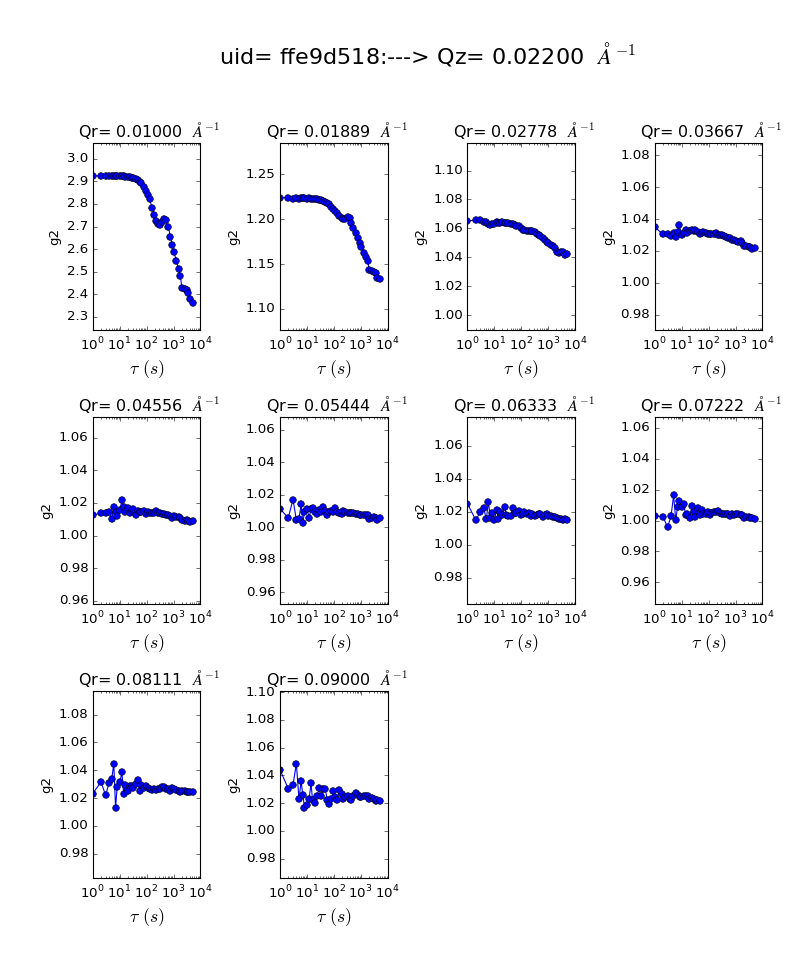

<IPython.core.display.Javascript object>


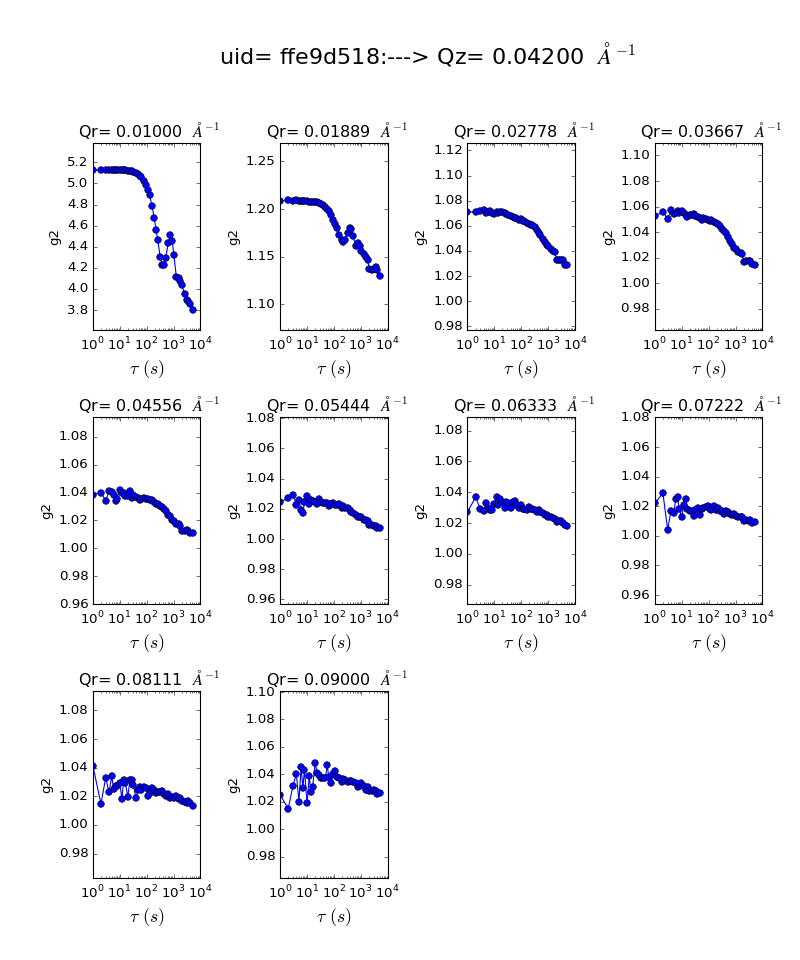

In [65]:
vmin = 1.1
vmax=  1.15

for qz_ind in range(num_qz):
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )
            
            
        y=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y, '-o', markersize=6) 
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  


#np.save( path + 'g2_%s--%s'%(good_start, good_end), [lags,g2])
#lags,g2 = np.load( path + 'g2_%s--%s.npy'%(good_start, good_end) )

# Fit g2

In [66]:
from lmfit import  Model
mod = Model(corr.auto_corr_scat_factor)


In [67]:
#plt.close('all')

<IPython.core.display.Javascript object>


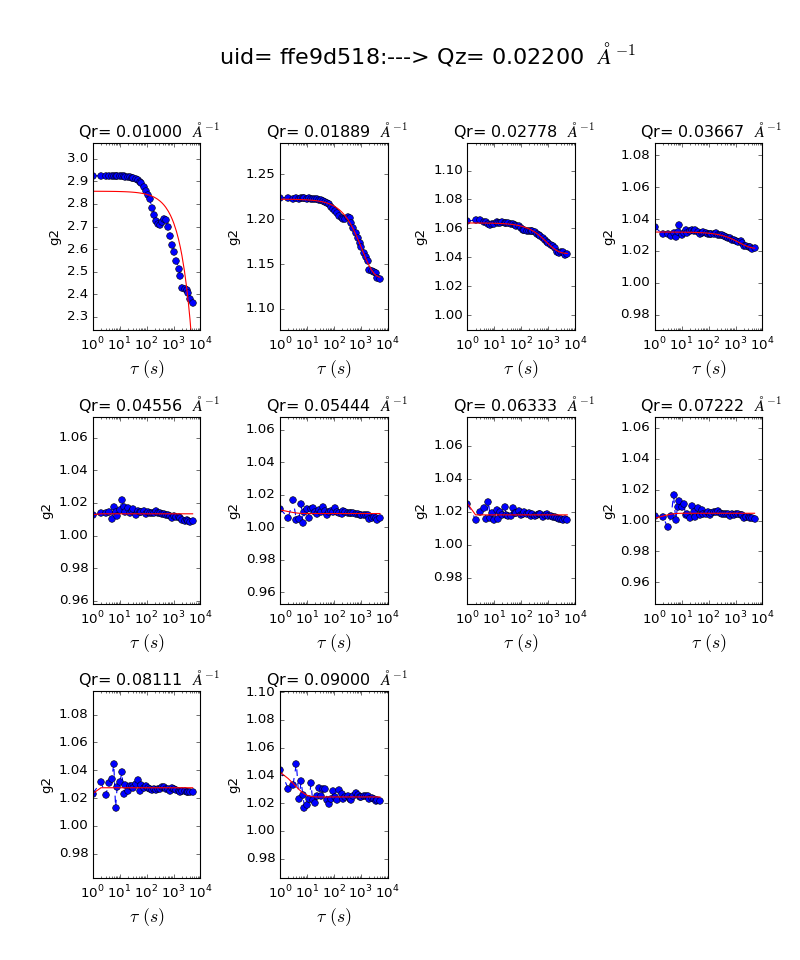

<IPython.core.display.Javascript object>


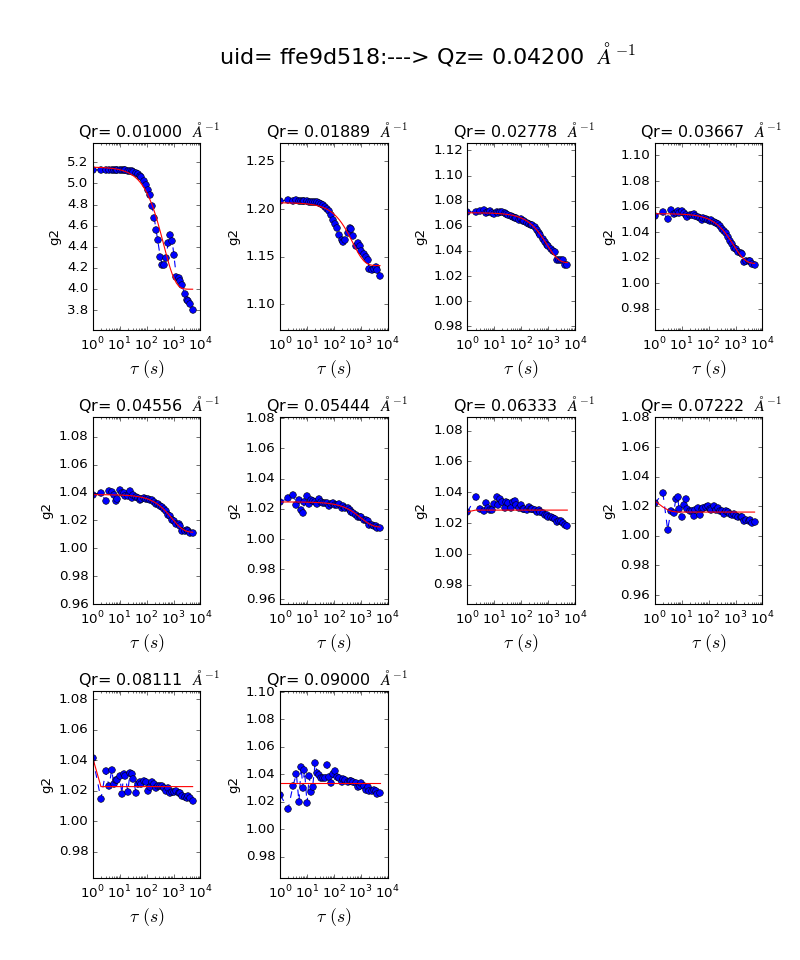

In [68]:
vmin = 1.1
vmax=  1.15

rate = {}

for qz_ind in range(num_qz):
    rate[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
            
        y=g2[1:, sn + qz_ind * num_qr]
        result1 = mod.fit(y, lags=lags[1:], beta=.1,
                      relaxation_rate =.5, baseline=1.0)
        rate[qz_ind].append(result1.best_values['relaxation_rate'])
    
        ax.semilogx(lags[1:], y, '--o', markersize=6) 
        ax.semilogx(lags[1:], result1.best_fit, '-r')
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  



## Plot the relaxation rates vs (q_ring_center)**2

In [ ]:
#plt.close('all')

In [ ]:
#rate

<IPython.core.display.Javascript object>


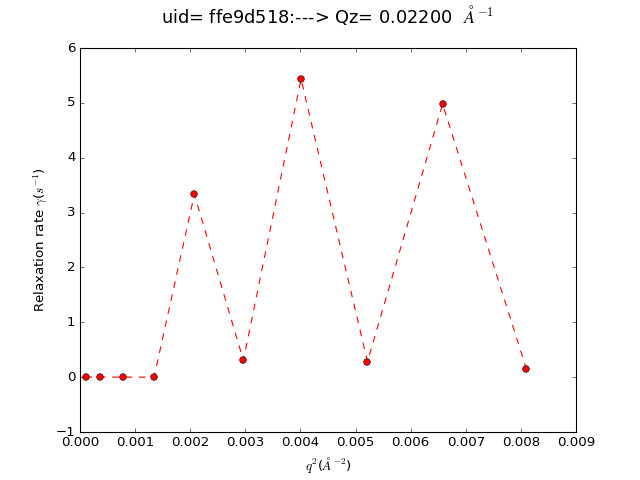

<IPython.core.display.Javascript object>


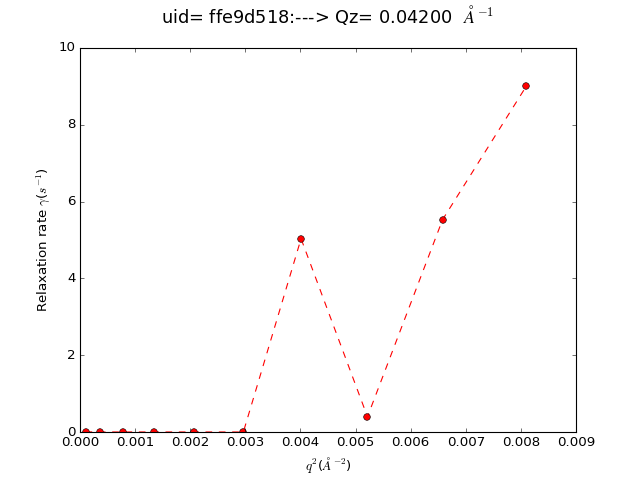

In [69]:
for qz_ind in range(num_qz):     
    #fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    fig, ax=plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05) 
    #print (qz_ind,title_qz)
    #if num_qz!=1:plt.axis('off')
        
    ax.plot(qr_center**2 , rate[qz_ind] , 'ro', ls='--')
    #ax.set_ylim( 0, 0.001)
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
    
    plt.show()
 

# Fitted the Diffusion Coefficinet D0

In [71]:
if True:
    D0={}
    gmfit={}
    for qz_ind in range(num_qz): 
        D0[qz_ind] = np.polyfit(qr_center**2, rate[qz_ind], 1)
        gmfit[qz_ind] = np.poly1d( D0[qz_ind] )
        print ('The fitted diffusion coefficient D0 is:  %.2E   A^2S-1'%D0[qz_ind][0])

The fitted diffusion coefficient D0 is:  2.83E+02   A^2S-1
The fitted diffusion coefficient D0 is:  1.00E+03   A^2S-1


<IPython.core.display.Javascript object>


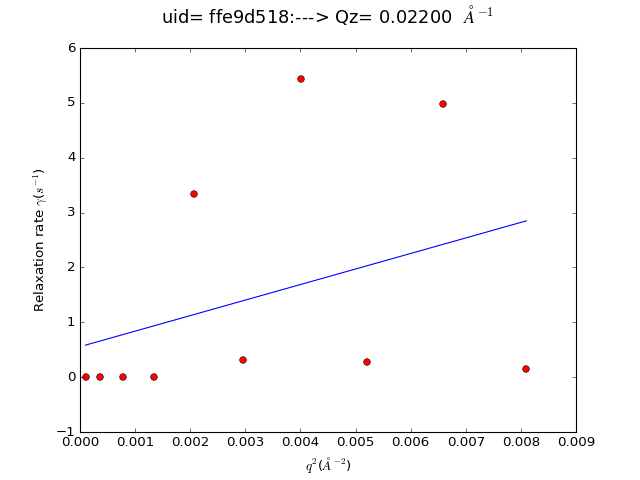

<IPython.core.display.Javascript object>


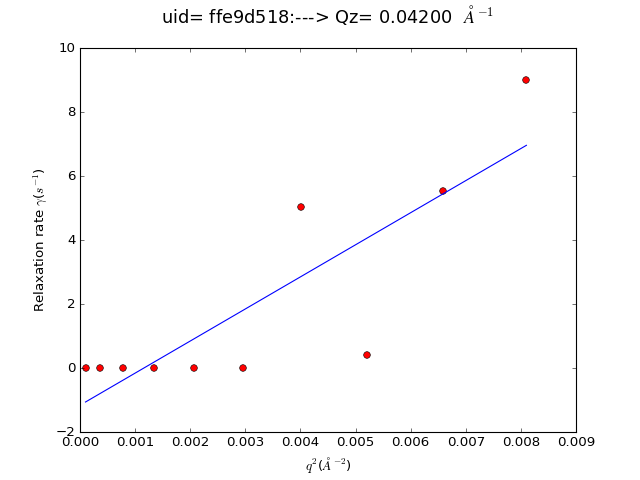

In [72]:
for qz_ind in range(num_qz): 
    fig,ax = plt.subplots()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=16, y =1.05)
    ax.plot(qr_center**2, rate[qz_ind], 'ro', ls='')
    ax.plot(qr_center**2,  gmfit[qz_ind](qr_center**2),  ls='-')
    ax.set_ylabel('Relaxation rate 'r'$\gamma$'"($s^{-1}$)")
    ax.set_xlabel("$q^2$"r'($\AA^{-2}$)')
plt.show()

# Two_time Correlation

In [73]:
good_start= 0
good_end = 15000
imgs_ =imgs[good_start: good_end]
imgsr = Reverse_Coordinate(imgs_, mask)

In [75]:
g12b = auto_two_Array( imgsr, box_maskr, data_pixel = data_pixel ) 

###########Total time: 13.57 min


In [ ]:
#g12b, g12b_not_norm, norms = auto_two_Array_g1_norm( imgsr, box_maskr,data_pixel = data_pixel ) 

In [ ]:
#np.save( path + 'g12b_%s-%s--%s'%(uid,good_start, good_end), g12b)
#data_pixel=[]

In [ ]:
#g12b, g12b_not_norm, norms = np.load(path + 'g12b_%s-%s--%s.npy'%(uid,good_start, good_end))

In [ ]:
#plt.close('all')

<IPython.core.display.Javascript object>


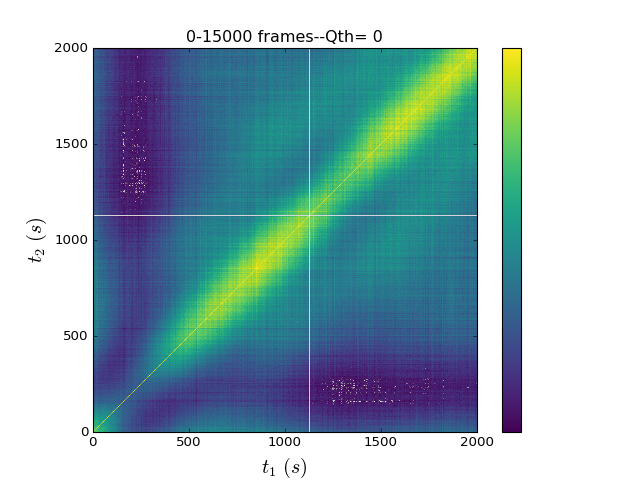

In [76]:
N1=0
N2= N1 + 2000
t0 = N1*timeperframe
g12_num = 0 #0: the firs box

data = g12b[N1:N2,N1:N2,g12_num]
fig, ax = plt.subplots()
im=ax.imshow( data, origin='lower' , cmap='viridis', 
             norm= LogNorm( vmin= 2.3, vmax= 3 ), 
        extent=[t0, t0 + data.shape[0]*timeperframe, t0, t0 + data.shape[0]*timeperframe ] )
ax.set_title('0-%s frames--Qth= %s'%(Nimg,g12_num))
ax.set_xlabel( r'$t_1$ $(s)$', fontsize = 18)
ax.set_ylabel( r'$t_2$ $(s)$', fontsize = 18)
fig.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


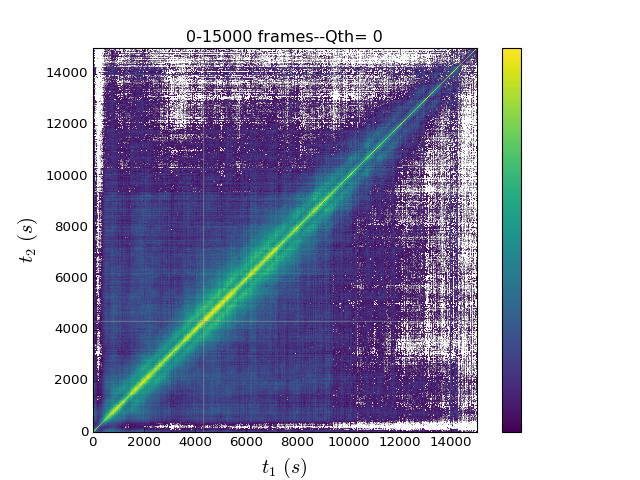

In [93]:
g12_num = 0  #0: the firs box
data = g12b[:,:,g12_num]
fig, ax = plt.subplots()
im=ax.imshow( data, origin='lower' , cmap='viridis', 
             norm= LogNorm( vmin= 2.3, vmax= 3 ), 
        extent=[0, data.shape[0]*timeperframe, 0, data.shape[0]*timeperframe ] )
ax.set_title('0-%s frames--Qth= %s'%(Nimg,g12_num))
ax.set_xlabel( r'$t_1$ $(s)$', fontsize = 18)
ax.set_ylabel( r'$t_2$ $(s)$', fontsize = 18)
fig.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


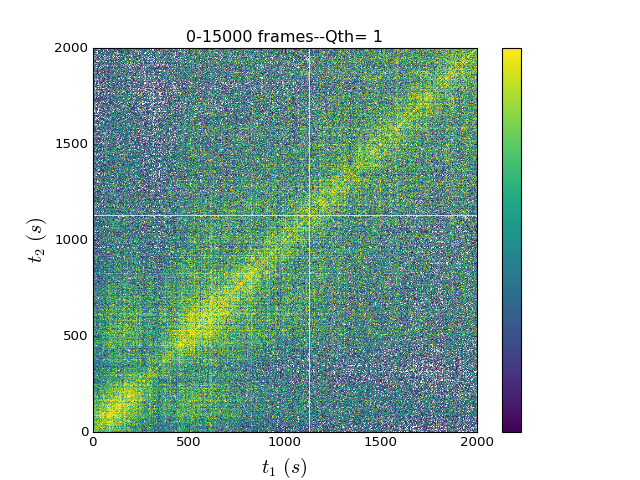

In [94]:
N1=0
N2= N1 + 2000
t0 = N1*timeperframe
g12_num =1 #0: the firs box

data = g12b[N1:N2,N1:N2,g12_num]
fig, ax = plt.subplots()
im=ax.imshow( data, origin='lower' , cmap='viridis', 
             norm= LogNorm( vmin= 1.12, vmax= 1.22 ), 
        extent=[t0, t0 + data.shape[0]*timeperframe, t0, t0 + data.shape[0]*timeperframe ] )
ax.set_title('0-%s frames--Qth= %s'%(Nimg,g12_num))
ax.set_xlabel( r'$t_1$ $(s)$', fontsize = 18)
ax.set_ylabel( r'$t_2$ $(s)$', fontsize = 18)
fig.colorbar(im)
plt.show()

<IPython.core.display.Javascript object>


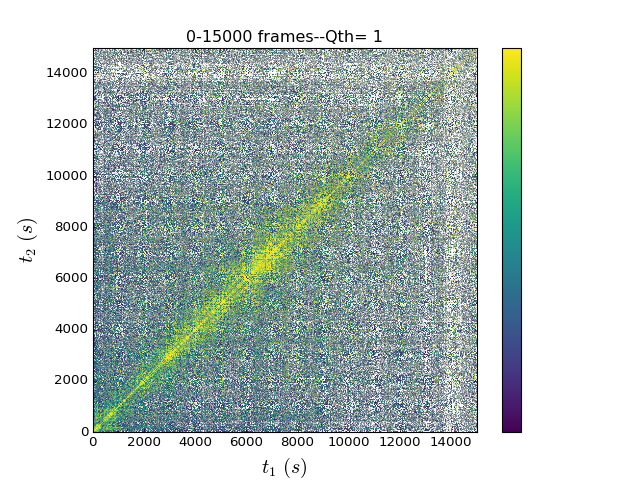

In [95]:
g12_num = 1  #0: the second box
data = g12b[:,:,g12_num]
fig, ax = plt.subplots()
im=ax.imshow( data, origin='lower' , cmap='viridis', 
             norm= LogNorm( vmin= 1.12, vmax= 1.22 ), 
        extent=[0, data.shape[0]*timeperframe, 0, data.shape[0]*timeperframe ] )
ax.set_title('0-%s frames--Qth= %s'%(Nimg,g12_num))
ax.set_xlabel( r'$t_1$ $(s)$', fontsize = 18)
ax.set_ylabel( r'$t_2$ $(s)$', fontsize = 18)
fig.colorbar(im)
plt.show()

## find the bad frames and mask it in two-time correlation

In [101]:
bad_frames

array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784])

In [102]:
g12b_mask = make_g12_mask(bad_frames, g12b[:,:,0].shape)

In [103]:
g12bm  =  masked_g12( g12b, bad_frames) 

<IPython.core.display.Javascript object>


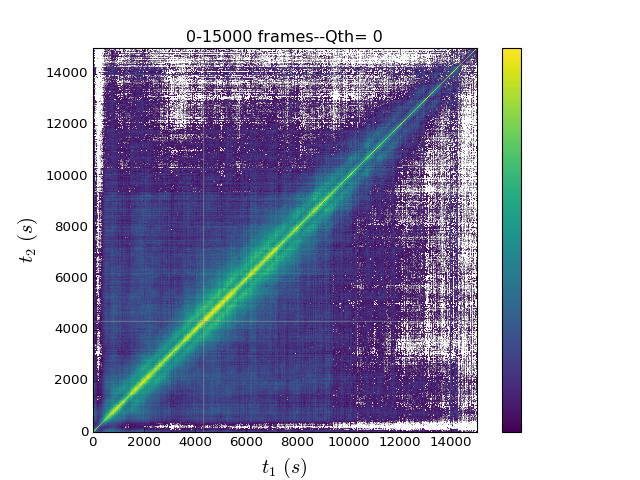

In [96]:
g12_num = 0  #0: the firs box
data = g12b[:,:,g12_num]
fig, ax = plt.subplots()
im=ax.imshow( data, origin='lower' , cmap='viridis', 
             norm= LogNorm( vmin= 2.3, vmax= 3 ), 
        extent=[0, data.shape[0]*timeperframe, 0, data.shape[0]*timeperframe ] )
ax.set_title('0-%s frames--Qth= %s'%(Nimg,g12_num))
ax.set_xlabel( r'$t_1$ $(s)$', fontsize = 18)
ax.set_ylabel( r'$t_2$ $(s)$', fontsize = 18)
fig.colorbar(im)
plt.show()

### get one time correlation

In [104]:
g2b = get_one_time_from_two_time(g12bm)

<IPython.core.display.Javascript object>


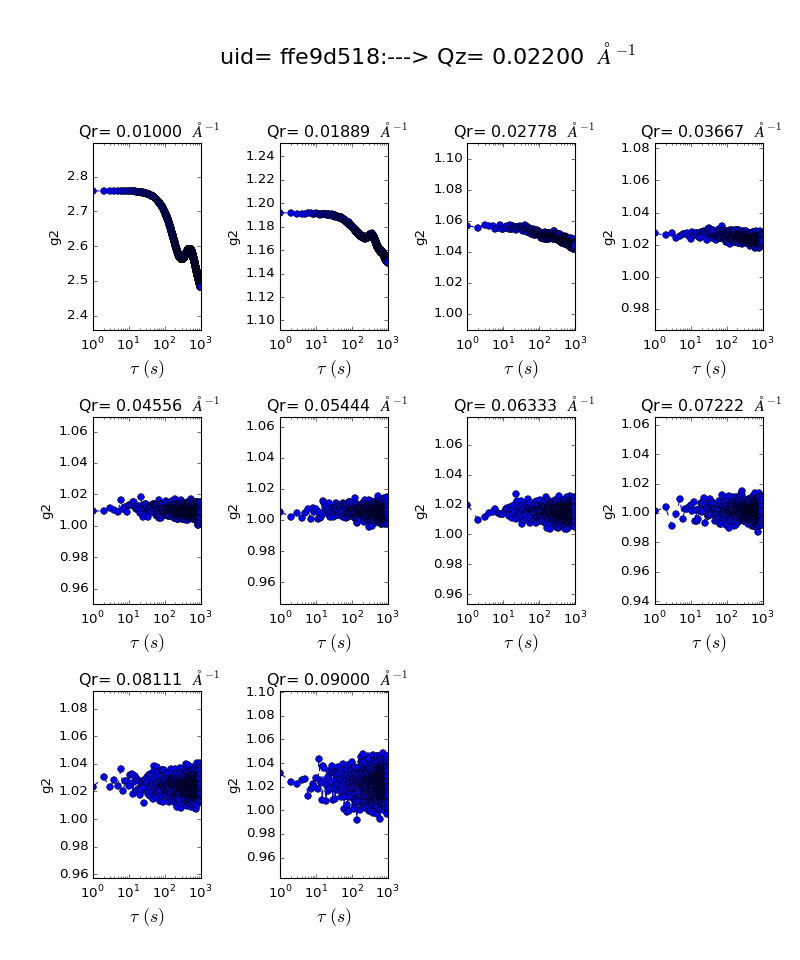

<IPython.core.display.Javascript object>


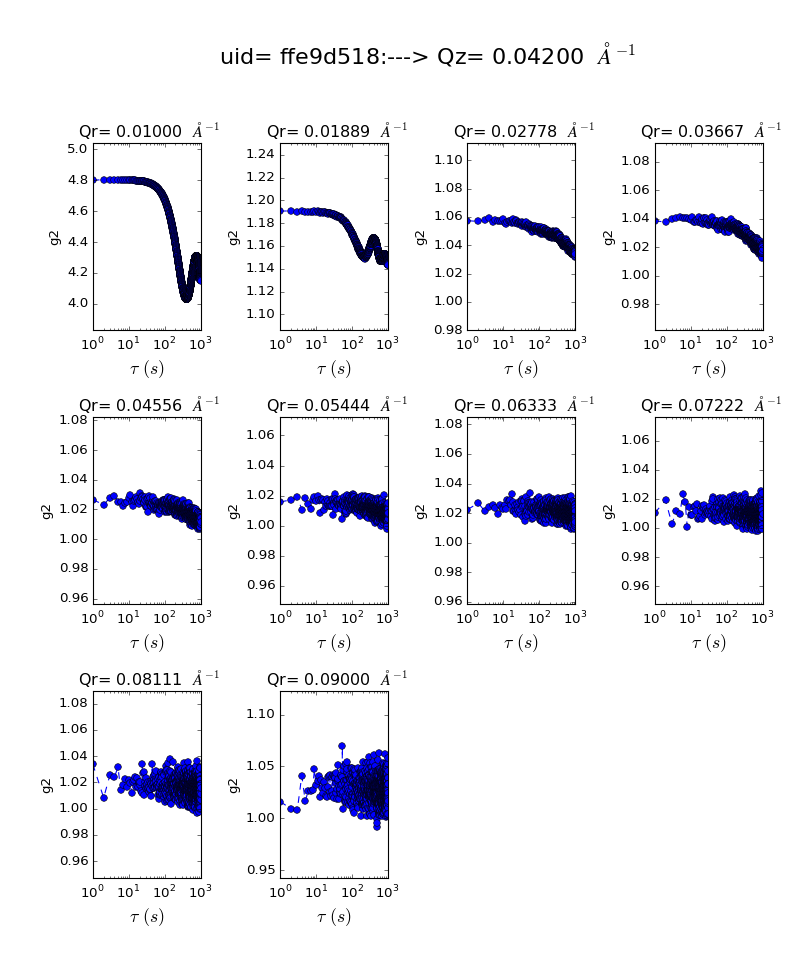

In [105]:
vmin = 1.0
vmax=  1.2

#rate_g2b = {}

for qz_ind in range(num_qz):
    #rate_g2b[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
        
        #print (sn + qz_ind * num_qr)
        y= g2b[:1000, sn + qz_ind * num_qr]
        x= np.arange(len(y))*timeperframe
        #print (x[1:])
        #y=g2b[1:, sn + qz_ind * num_qr]
        #result1 = mod.fit(y, lags=x[1:], beta=.1, relaxation_rate =.5, baseline=1.0)
        #rate_g2b[qz_ind].append(result1.best_values['relaxation_rate'])
    
        if not isnan(y.mean()):ax.semilogx( x[1:],  y[1:] , '--o', markersize=6) 
        #ax.plot(x[1:], y[1:], '--o', markersize=6) 
        #ax.semilogx(x[1:], result1.best_fit, '-r')
        ax.set_ylim([min(y[1:])*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  

### plot g2 by multi-tau and g2 from two-time

<IPython.core.display.Javascript object>


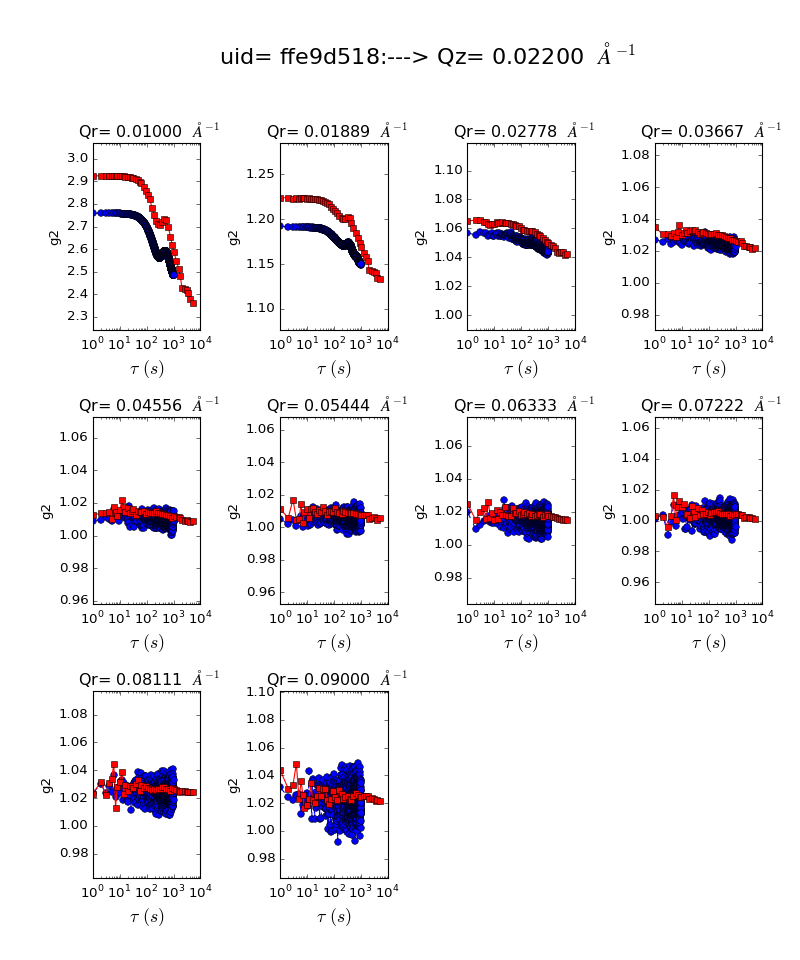

<IPython.core.display.Javascript object>


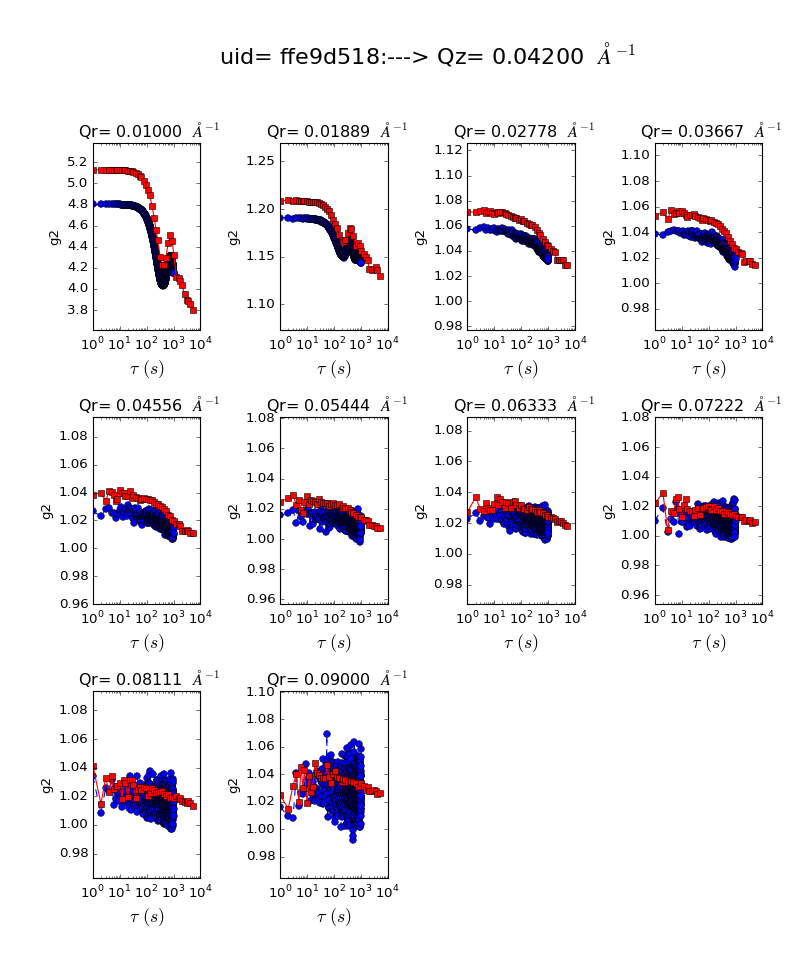

In [106]:
vmin = 1.0
vmax=  1.2

#rate_g2b = {}

for qz_ind in range(num_qz):
    #rate_g2b[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
        
        #print (sn + qz_ind * num_qr)
        y= g2b[:1000, sn + qz_ind * num_qr]
        x= np.arange(len(y))*timeperframe
        #print (x[1:])
        #y=g2b[1:, sn + qz_ind * num_qr]
        #result1 = mod.fit(y, lags=x[1:], beta=.1, relaxation_rate =.5, baseline=1.0)
        #rate_g2b[qz_ind].append(result1.best_values['relaxation_rate'])
    
        if not isnan(y.mean()):ax.semilogx( x[1:],  y[1:] , '--o', markersize=6) 
        #ax.plot(x[1:], y[1:], '--o', markersize=6) 
        #ax.semilogx(x[1:], result1.best_fit, '-r')
        
        y2=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y2, '-rs', markersize=6) 
        #ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        
        ax.set_ylim([min(y2[1:])*.95, max(y2[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  

## Another defination of two-time correlation (different normalization)

In [87]:
g12b, g12b_not_norm, norms = auto_two_Array_g1_norm( imgsr, 
                                    box_maskr,data_pixel = data_pixel ) 

###########Total time: 15.91 min


In [107]:
bad_frames

array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784])

In [108]:
g12b_not_norm_m  =  masked_g12( g12b_not_norm, bad_frames ) 

In [109]:
g2b_norm = g2b

In [110]:
g2b_not_norm = get_one_time_from_two_time(  g12b_not_norm_m,  norms=norms,  nopr=nopr  )

<IPython.core.display.Javascript object>


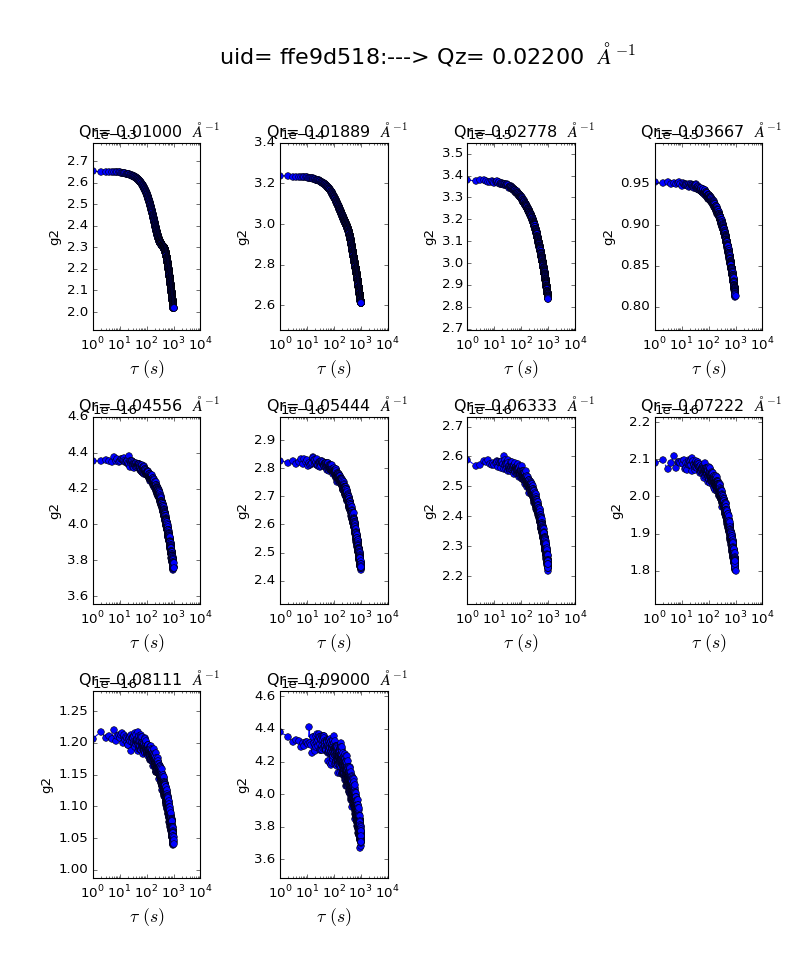

<IPython.core.display.Javascript object>


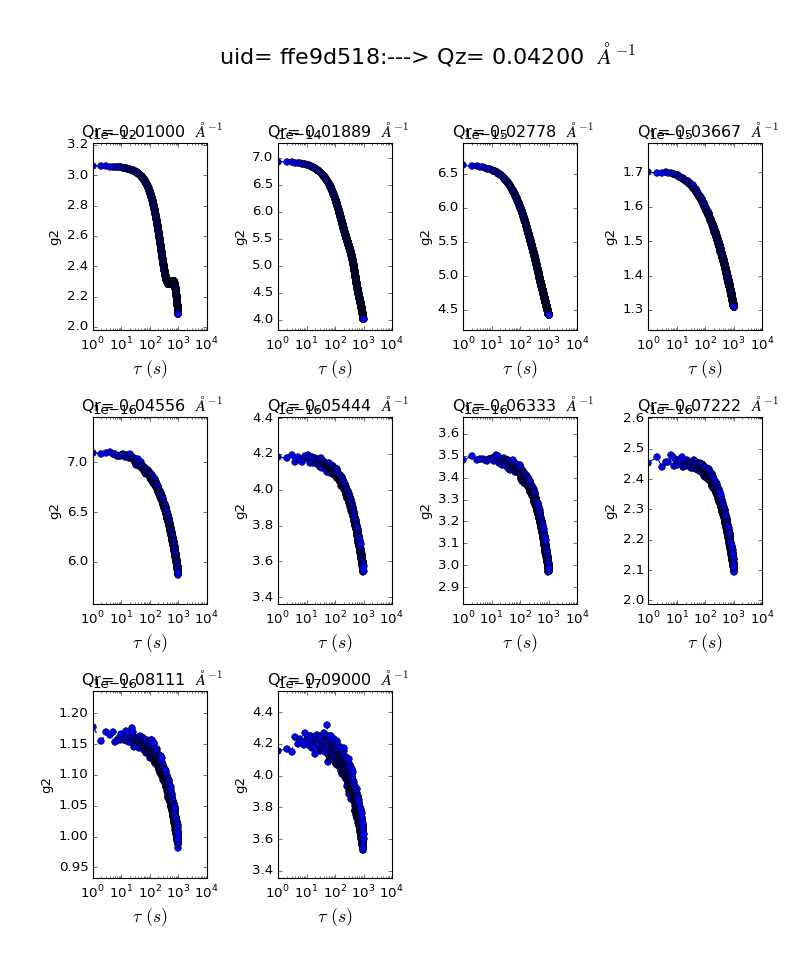

In [111]:
vmin = 1.0
vmax=  1.2

#rate_g2b = {}

for qz_ind in range(num_qz):
    #rate_g2b[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
        
        #print (sn + qz_ind * num_qr)
        y= g2b_not_norm[:1000, sn + qz_ind * num_qr]
        x= np.arange(len(y))*timeperframe
        #print (x[1:])
        #y=g2b[1:, sn + qz_ind * num_qr]
        #result1 = mod.fit(y, lags=x[1:], beta=.1, relaxation_rate =.5, baseline=1.0)
        #rate_g2b[qz_ind].append(result1.best_values['relaxation_rate'])
    
        if not isnan(y.mean()):ax.semilogx( x[1:],  y[1:] , '--o', markersize=6) 
        #ax.plot(x[1:], y[1:], '--o', markersize=6) 
        #ax.semilogx(x[1:], result1.best_fit, '-r')
        
        y2=g2[:, sn + qz_ind * num_qr]
        ax.semilogx(lags, y2, '-r', markersize=3) 
        ax.set_ylim([min(y)*.95, max(y[1:])*1.05 ])
        
        #ax.set_ylim([min(y2[1:])*.95, max(y2[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  

### get one time correlation @different age

In [112]:
g2_aged = get_aged_g2_from_g12q( g12bm[:,:,1], slice_num =3, slice_width= 500, 
                slice_start=8000, slice_end= 2*15000-8000)

the cut age centers are: [8000, 15000, 22000]


<IPython.core.display.Javascript object>


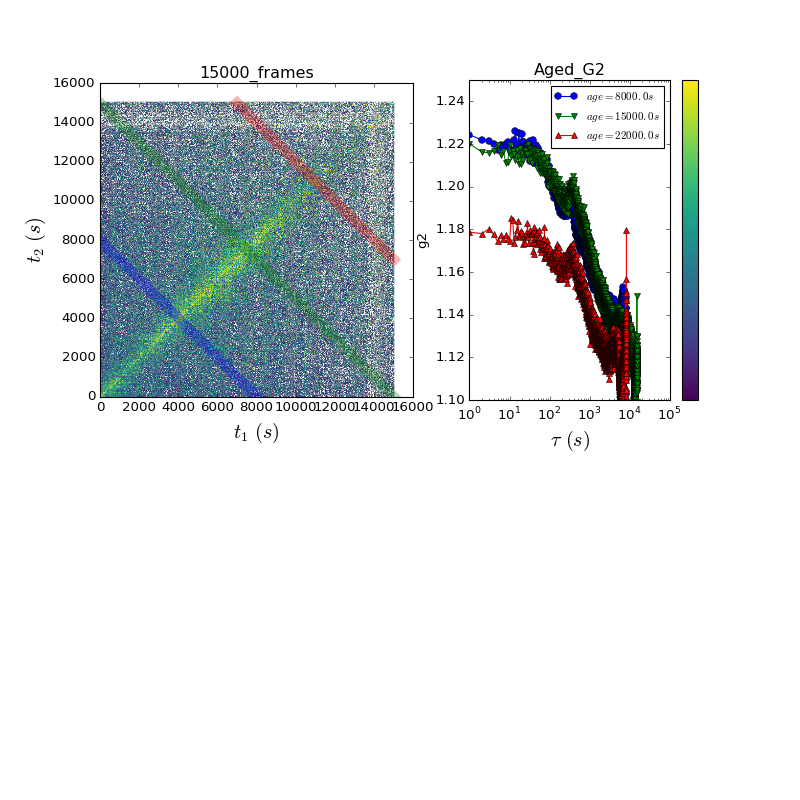

In [113]:
show_g12q_aged_g2( g12bm[:,:,1], g2_aged,slice_width= 500,
                  timeperframe=1,vmin= 1.1, vmax= 1.25 )

# get taus histgram

In [114]:
taus = get_tau_from_g12q( g12bm[:,:,1], slice_num = 5, slice_width=1, 
                  slice_start=3, slice_end= 10000-1  )

the cut tau centers are: [5001, 3, 7500, 2502, 9999]


<IPython.core.display.Javascript object>


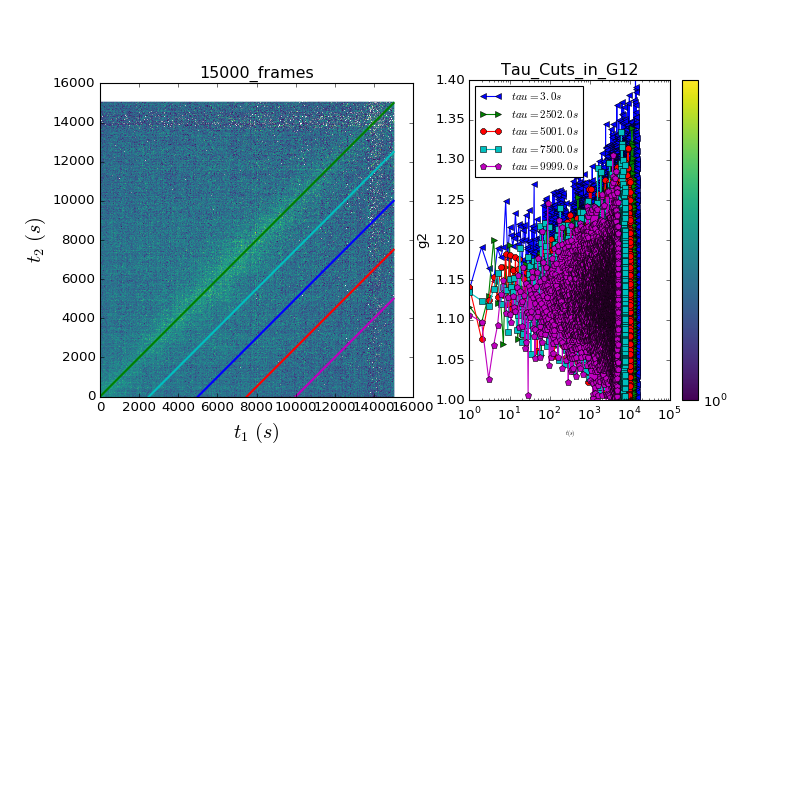

In [115]:
show_g12q_taus( g12bm[:,:,1], taus,  slice_width=50, 
               timeperframe=1,vmin=1.00,vmax=1.4 )

<IPython.core.display.Javascript object>


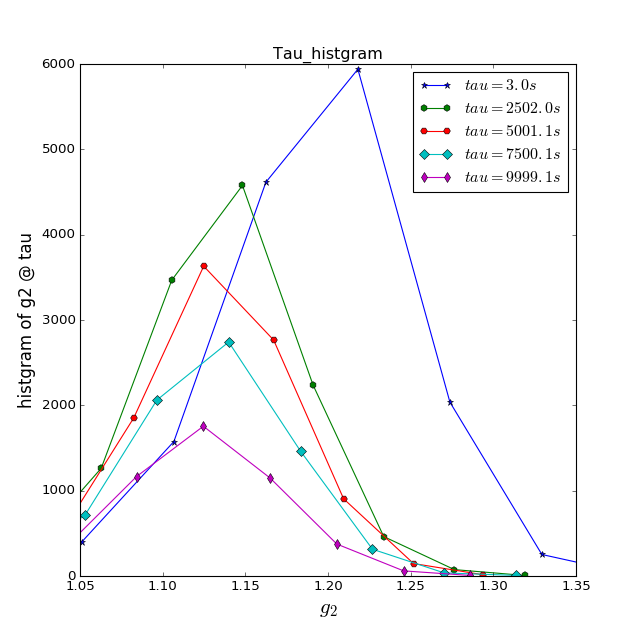

In [116]:
his = histogram_taus(taus, hisbin=10, plot=True, timeperframe=timeperframe)

# four-time correlation

In [117]:
bad_frames

array([ 1124,  1245,  4304,  6645,  7245, 12584, 13784])

In [118]:
s1,s2 = 0,2000

In [119]:
g4 = get_four_time_from_two_time( g12bm, g2b, rois=[s1,s2,s1,s2] )


### plot four-time correlation function

<IPython.core.display.Javascript object>


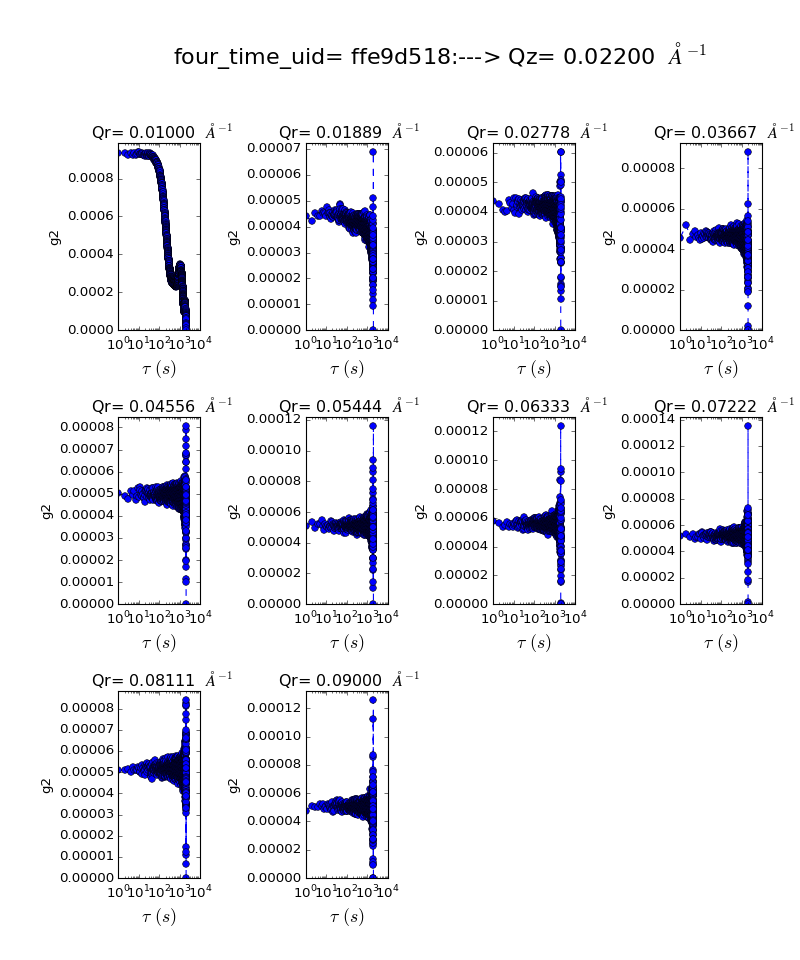

<IPython.core.display.Javascript object>


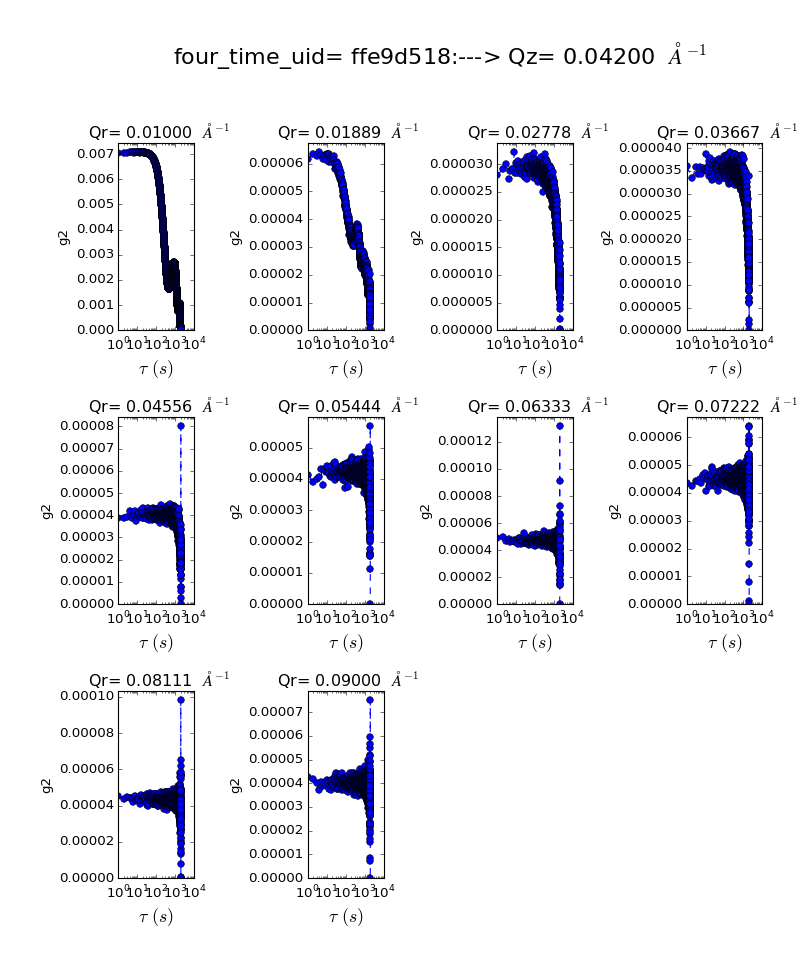

In [120]:
vmin = 1.0
vmax=  1.2

#rate_g2b = {}

for qz_ind in range(num_qz):
    #rate_g2b[qz_ind] =[]
    fig = plt.figure(figsize=(10, 12))
    #fig = plt.figure()
    title_qz = ' Qz= %.5f  '%( qz_center[qz_ind]) + r'$\AA^{-1}$' 
    plt.title('four_time_uid= %s:--->'%uid + title_qz,fontsize=20, y =1.1) 
    #print (qz_ind,title_qz)
    if num_qz!=1:plt.axis('off')
    sx = int(round(np.sqrt(num_qr)) )
    if num_qr%sx == 0: 
        sy = int(num_qr/sx)
    else:
        sy=int(num_qr/sx+1) 
    for sn in range(num_qr):
        
        ax = fig.add_subplot(sx,sy,sn+1 )
        ax.set_ylabel("g2") 
        ax.set_xlabel(r"$\tau $ $(s)$", fontsize=16) 
               
        title_qr = " Qr= " + '%.5f  '%( qr_center[sn]) + r'$\AA^{-1}$'
        if num_qz==1:
            
            title = 'four_time_uid= %s:--->'%uid + title_qz + '__' +  title_qr
        else:
            title = title_qr
        ax.set_title( title  )           
        
        #print (sn + qz_ind * num_qr)
        y= g4[:, sn + qz_ind * num_qr]
        x= np.arange(len(y))*timeperframe
        #print (x[1:])
        #y=g2b[1:, sn + qz_ind * num_qr]
        #result1 = mod.fit(y, lags=x[1:], beta=.1, relaxation_rate =.5, baseline=1.0)
        #rate_g2b[qz_ind].append(result1.best_values['relaxation_rate'])
    
        if not isnan(y.mean()):ax.semilogx( x[1:],  y[1:] , '--o', markersize=6) 
        #ax.plot(x[1:], y[1:], '--o', markersize=6) 
        #ax.semilogx(x[1:], result1.best_fit, '-r')
        ax.set_ylim([min(y[1:])*.95, max(y[1:])*1.05 ])
        #ax.set_ylim( vmin, vmax)
        
    plt.show()
    fig.tight_layout()  

# The End